<a href="https://colab.research.google.com/github/FernandoBRdgz/inteligencia_artificial/blob/main/aprendizaje_reforzado/q_aprendizaje_taxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Ejemplo de diseño: Taxi auto-conducido

En este ejemplo se va a diseñar una simulación de un taxi auto-conducido. El objetivo principal es demostrar, en un entorno simplificado, cómo se pueden utilizar las técnicas de RL para desarrollar un enfoque eficiente y seguro para abordar el problema.

El trabajo del SmartCab es recoger al pasajero en un lugar y dejarlo en otro. Estas son algunas de las cosas de las que nos gustaría que nuestro smartcab se encargara:

- Dejar al pasajero en el lugar correcto
- Ahorrar tiempo al pasajero tardando lo mínimo posible en dejarle.
- Cuidar la seguridad del pasajero y las normas de tráfico

Hay diferentes aspectos que hay que considerar aquí mientras se modela una solución RL para este problema: recompensas, estados y acciones.

#### 1 Recompensas

Dado que el agente (el conductor imaginario) está motivado por la recompensa y va a aprender a controlar el taxi mediante experiencias de prueba de entorno, tenemos que decidir las recompensas y/o penalizaciones y su magnitud en consecuencia. He aquí algunos puntos a tener en cuenta:

- El agente debe recibir una alta recompensa positiva por una entrega exitosa porque este comportamiento es muy deseado
- El agente debe ser penalizado si intenta dejar a un pasajero en lugares equivocados
- El agente debería recibir una ligera recompensa negativa por no llegar al destino después de cada paso de tiempo. "Ligeramente" negativo porque preferimos que nuestro agente llegue tarde en lugar de hacer movimientos erróneos tratando de llegar al destino lo más rápido posible.

#### 2. Espacio de estados

En el aprendizaje por refuerzo, el agente se encuentra con un estado, y entonces toma una acción de acuerdo con el estado en el que se encuentra.

El espacio de estados es el conjunto de todas las situaciones posibles en las que puede encontrarse nuestro taxi. El estado debe contener información útil que el agente necesita para realizar la acción correcta.

Digamos que tenemos un área de entrenamiento para nuestro SmartCab en el que le estamos enseñando a transportar personas en un aparcamiento a cuatro lugares diferentes (R,G,Y,B):

<img src='https://storage.googleapis.com/lds-media/images/Reinforcement_Learning_Taxi_Env.width-1200.png'>

Supongamos que Smartcab es el único vehículo en este estacionamiento. Podemos dividir el estacionamiento en una cuadrícula de 5x5, lo que nos brinda 25 posibles ubicaciones de taxis. Estos 25 lugares son una parte de nuestro espacio de estados. Observe que el estado de ubicación actual de nuestro taxi es la coordenada (3, 1).

También notará que hay cuatro (4) ubicaciones en las que podemos recoger y dejar a un pasajero: R, G, Y, B o `[(0,0), (0,4), (4,0), (4,3)]` en (fila, columna) coordenadas. Nuestro pasajero ilustrado está en la ubicación Y y desea ir a la ubicación R.

Cuando también contabilizamos un (1) estado de pasajero adicional dentro del taxi, podemos tomar todas las combinaciones de ubicaciones de pasajeros y ubicaciones de destino para llegar a un número total de estados para nuestro entorno de taxi; hay cuatro (4) destinos y cinco (4 + 1) ubicaciones de pasajeros.

Por lo tanto, nuestro entorno de taxi tiene un total de 5x5x5x4=500 estados posibles.

#### 3. Espacio de acción

El agente se encuentra con uno de los 500 estados y realiza una acción. La acción en nuestro caso puede ser moverse en una dirección o decidir recoger/dejar a un pasajero.

En otras palabras, tenemos seis acciones posibles:

1. Sur
2. Norte
3. Este
4. Oeste
5. Recoger un pasajero
6. Dejar al pasajero


Este es el espacio de acción : el conjunto de todas las acciones que nuestro agente puede realizar en un estado dado.

Notarás en la ilustración de arriba que el taxi no puede realizar ciertas acciones en ciertos estados debido a las paredes. En el código del entorno, simplemente proporcionaremos una penalización de -1 por cada pared golpeada y el taxi no se moverá a ningún lado. Esto solo acumulará multas que harán que el taxi considere dar la vuelta a la pared.

### Implementación con Python

Afortunadamente, OpenAI Gym tiene este entorno exacto ya creado para nosotros.

Gym proporciona diferentes entornos de juego que podemos conectar a nuestro código y probar un agente. La biblioteca se encarga de la API para proporcionar toda la información que nuestro agente requiera, como posibles acciones, puntuación y estado actual. Solo tenemos que centrarnos en la parte del algoritmo para nuestro agente.

Usaremos el entorno Gym llamado Taxi-V2, del cual se extrajeron todos los detalles explicados anteriormente. Los objetivos, recompensas y acciones son todos iguales.

Necesitamos instalar gym primero. Ejecutar lo siguiente en un cuaderno Jupyter debería funcionar:

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [2]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [3]:
!pip install gym[toy_text]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 29.2 MB/s eta 0:00:00


Una vez instalado, podemos cargar el entorno del juego y renderizar lo que parece:

In [4]:
import gym
import time
import numpy as np
import matplotlib.pyplot as plt

from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
display = Display(visible=0, size=(400, 300))
display.start()

In [7]:
env = gym.make('Taxi-v3')
# env.reset()

In [8]:
state = env.reset()
print(f"Initial state: {state}")

Initial state: 149


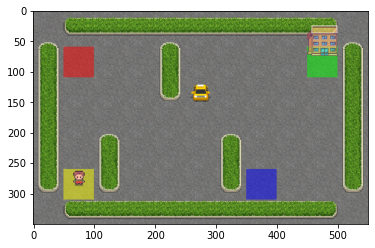

In [9]:
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen);

La interfaz núcleo de la librería gym es `env`, que es la interfaz de entorno unificado. Los siguientes son los métodos `env` que nos serían muy útiles:

- `env.reset()`: reinicia el entorno y devuelve un estado inicial aleatorio.
- `env.step(action)`: Desplaza el agente por un paso de tiempo y además devuelve:

    * observación : Observaciones del entorno
    * recompensa : si tu acción fue beneficiosa o no
    * hecho : Indica si hemos recogido y dejado con éxito a un pasajero, también llamado episodio único
    * información : información adicional como el rendimiento y la latencia con fines de depuración

- `env.render()`: Renderiza un fotograma del entorno (útil para visualizar el entorno)

## Recordatorio de nuestro problema

Aquí está nuestra declaración de problema reestructurada (de Gym docs):

"Hay 4 ubicaciones (etiquetadas con letras diferentes), y nuestro trabajo es recoger al pasajero en una ubicación y dejarlo en otra. Recibimos +20 puntos por una entrega exitosa y perdemos 1 punto por cada vez- paso que toma. También hay una penalización de 10 puntos por acciones ilegales de recogida y entrega".

Vamos a sumergirnos más en el medio ambiente.

In [15]:
env.reset() # reset environment to a new, random state
env.render(mode='rgb_array')

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Action Space Discrete(6)
State Space Discrete(500)


- El cuadrado relleno representa el taxi, que es amarillo sin pasajero y verde con pasajero.
- La tubería ("|") representa una pared que el taxi no puede cruzar.
- R, G, Y, B son las posibles ubicaciones de recogida y destino. La letra azul representa el lugar actual de recogida de pasajeros y la letra morada es el destino actual.

Como se verifica en las impresiones, tenemos un espacio de acción de tamaño 6 y un espacio de estado de tamaño 500. Como verá, nuestro algoritmo RL no necesitará más información que estas dos cosas. Todo lo que necesitamos es una forma de identificar un estado de manera única asignando un número único a cada estado posible, y RL aprende a elegir un número de acción del 0 al 5 donde:

- 0 = sur
- 1 = norte
- 2 = este
- 3 = oeste
- 4 = recoger
- 5 = dejar

Recuerde que los 500 estados corresponden a una codificación de la ubicación del taxi, la ubicación del pasajero y la ubicación de destino.

El aprendizaje por refuerzo aprenderá un mapeo de estados a la acción óptima para realizar en ese estado por exploración , es decir, el agente explora el entorno y realiza acciones en función de las recompensas definidas en el entorno.

La acción óptima para cada estado es la acción que tiene la mayor recompensa acumulada a largo plazo.

## Volver a nuestra ilustración

De hecho, podemos tomar nuestra ilustración anterior, codificar su estado y dárselo al entorno para que se renderice en Gym. Recuerde que tenemos el taxi en la fila 3, columna 1, nuestro pasajero está en la ubicación 2 y nuestro destino es la ubicación 0. Usando el método de codificación de estado Taxi-v2, podemos hacer lo siguiente:

In [17]:
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render(mode='rgb_array')

State: 328


array([[[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[110, 109, 106],
        [110, 109, 106],
        [124, 122, 122],
        ...,
        [108, 111, 109],
        [108, 111, 109],
        [118, 119, 119]],

       [[114, 116, 115],
        [114, 116, 115],
        [126, 127, 126],
        ...,
        [112, 113, 111],
        [112, 113, 111],
        [118, 117, 115]],

       ...,

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[116, 115, 116],
        [116, 115, 116],
        [106, 107, 108],
        ...,
        [113, 115, 114],
        [113, 115, 114],
        [117, 114, 117]],

       [[115, 112, 112],
        [115, 112, 112],
        [119, 119, 117],
        ...,
        [123, 119, 118],
        [123, 119, 118],
        [114, 114, 117]]

Estamos usando las coordenadas de nuestra ilustración para generar un número correspondiente a un estado entre 0 y 499, que resulta ser 328 para el estado de nuestra ilustración.

Luego, podemos configurar el estado del entorno manualmente env.env.susando ese número codificado. Puedes jugar con los números y verás que el taxi, el pasajero y el destino se mueven.

#### La mesa de recompensas

Cuando se crea el entorno Taxi, también se crea una tabla de Recompensas inicial, llamada `P`. Podemos pensar en ella como una matriz que tiene el número de estados como filas y el número de acciones como columnas, es decir, una matriz de `estados x acciones`.

Dado que cada estado está en esta matriz, podemos ver los valores de recompensa predeterminados asignados al estado de nuestra ilustración:

In [21]:
env.P[328]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

Este diccionario tiene la estructura `{action: [(probability, nextstate, reward, done)]}`.

Algunas cosas a tener en cuenta:

El 0-5 corresponde a las acciones (sur, norte, este, oeste, recoger, dejar) que el taxi puede realizar en nuestro estado actual en la ilustración.
En este entorno, `probability` siempre es 1.0.
El `nextstate` es el estado en el que estaríamos si tomamos la acción en este índice del dict
Todas las acciones de movimiento tienen una recompensa de -1 y las acciones de recoger/dejar tienen una recompensa de -10 en este estado en particular. Si estamos en un estado donde el taxi tiene un pasajero y está encima del destino correcto, veríamos una recompensa de 20 en la acción de entrega (5)
`done` se utiliza para decirnos cuándo hemos dejado con éxito a un pasajero en el lugar correcto. Cada entrega exitosa es el final de un episodio.

Tenga en cuenta que si nuestro agente elige explorar la acción dos (2) en este estado, se dirigirá hacia el este contra una pared. El código fuente ha hecho que sea imposible mover el taxi a través de una pared, por lo que si el taxi elige esa acción, seguirá acumulando penalizaciones de -1, lo que afecta la recompensa a largo plazo

### Resolviendo el entorno sin Aprendizaje por Refuerzo

Veamos qué pasaría si tratamos de resolver el problema por fuerza bruta sin RL.

Dado que tenemos nuestra tabla `P` de recompensas predeterminadas en cada estado, podemos intentar que nuestro taxi navegue solo con eso.

Crearemos un ciclo infinito que se ejecuta hasta que un pasajero llega a un destino (un episodio ), o en otras palabras, cuando la recompensa recibida es 20. El `env.action_space.sample()` método selecciona automáticamente una acción aleatoria del conjunto de todas las acciones posibles.

Veamos qué pasa:

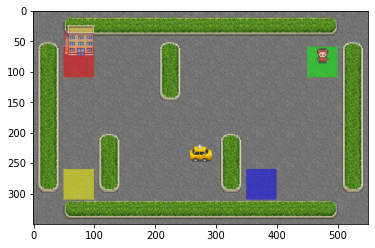

In [20]:
num_steps = 50
for s in range(50):
    print(f"step: {s} out of {num_steps}")
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    screen = env.render(mode='rgb_array')
    time.sleep(0.5)
    plt.imshow(screen);
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

    if done:
        break
    
ipythondisplay.clear_output(wait=True)
env.close()

No es bueno. Nuestro agente toma miles de pasos de tiempo y hace muchas devoluciones incorrectas para llevar a un solo pasajero al destino correcto.

Esto se debe a que no estamos aprendiendo de la experiencia pasada. Podemos ejecutar esto una y otra vez, y nunca se optimizará. El agente no tiene memoria de qué acción fue la mejor para cada estado, que es exactamente lo que el aprendizaje por refuerzo hará por nosotros.

## Introduzca el aprendizaje por refuerzo

Vamos a utilizar un algoritmo RL simple llamado Q-learning que le dará algo de memoria a nuestro agente.

### Introducción a Q-learning